In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
def generate_adding_problem_data(num_samples, t_steps=6):
    X_num = np.random.uniform(low=0, high=1, size=(num_samples, t_steps, 1))
    X_mask = np.zeros((num_samples, t_steps, 1))
    Y = np.ones((num_samples, 1))
    for i in range(num_samples):
        # Default uniform distribution on position sampling
        positions = np.random.choice(t_steps, size=2, replace=False)
        X_mask[i, positions] = 1
        Y[i, 0] = np.sum(X_num[i, positions])
    X = np.append(X_num, X_mask, axis=2)
    return X, Y

In [3]:
class AddingProblemRNN(nn.Module):
    def __init__(self, input_size=2, hidden_size = 128, output_size=1, lr=0.001, t_steps=100, batch_size=100):
        super(AddingProblemRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.t_steps = t_steps
        self.batch_size = batch_size
        
        
        self.rnn = nn.RNN(input_size, hidden_size)
        torch.nn.init.eye_(self.rnn.weight_hh_l0)
        torch.nn.init.constant_(self.rnn.bias_hh_l0, 0)
        torch.nn.init.constant_(self.rnn.bias_ih_l0, 0)
        
        self.fc = nn.Linear(hidden_size, output_size)
        self.criterion = nn.MSELoss()
        self.opt = optim.Adam(self.parameters(), lr=lr)

    def forward(self, x, h):
        x = x.view(self.t_steps, self.batch_size, self.input_size)
        out, hidden = self.rnn(x, h)
        out = self.fc(out)
        return out, hidden

    def train_step(self, inputs, labels):
        h = torch.zeros(1, self.batch_size, self.hidden_size)
        self.opt.zero_grad()
        outputs, _ = self.forward(inputs, h)
        loss = self.criterion(outputs[-1], labels)
        loss.backward()
        self.opt.step()
        return loss.item()

    def predict(self, inputs):
        h = torch.zeros(1, self.batch_size, self.hidden_size)
        outputs, _ = self.forward(inputs, h)
        return outputs.squeeze(1).detach().numpy()

c:\ProgramData\Anaconda3\envs\bioai\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([100, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, train loss: 1.14956, test loss: 4.61266


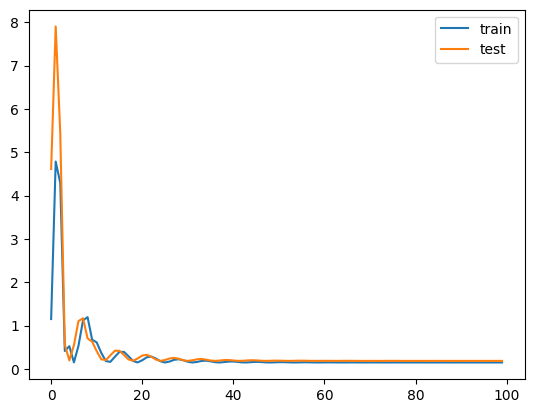

In [4]:
import matplotlib.pyplot as plt

# Set the hyperparameters
t_steps = 100
batch_size = 256
num_epochs = 100
lr = 0.01
hidden_size = 128

# Generate the training and testing data
X_train, y_train = generate_adding_problem_data(num_samples = batch_size, t_steps = t_steps)
X_test, y_test = generate_adding_problem_data(num_samples = batch_size, t_steps = t_steps)

# Initialize the model
model = AddingProblemRNN(input_size=2, hidden_size=hidden_size, output_size=1, lr=lr, t_steps=t_steps, batch_size=batch_size)

# Train the model
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    # Train on one batch of data
    train_loss = model.train_step(torch.tensor(X_train).float(), torch.tensor(y_train).float())
    train_losses.append(train_loss)

    # Test on one batch of data
    test_loss = model.criterion(torch.tensor(model.predict(torch.tensor(X_test).float())), torch.tensor(y_test).float())
    test_losses.append(test_loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, train loss: {train_loss:.5f}, test loss: {test_loss.item():.5f}")

# Plot the training and testing losses
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.legend()
plt.show()

In [5]:
X_test, y_test = generate_adding_problem_data(num_samples = batch_size, t_steps = t_steps)
def measure_accuracy(model, X, Y):
    # Get predicted outputs from the model
    Y_pred = model.predict(torch.tensor(X).float())

    # Round predicted values to the nearest integer
    Y_pred = np.round(Y_pred)

    # Compute the accuracy as the fraction of correct predictions
    accuracy = np.mean((Y_pred - Y) < 0.05)

    return accuracy

print(measure_accuracy(model, X_test, y_test))

0.6016796875


In [7]:
num_epochs=50
accuracies = []
for t in range(2, 80, 2):
    X_train, y_train = generate_adding_problem_data(num_samples = batch_size, t_steps = t)
    X_test, y_test = generate_adding_problem_data(num_samples = batch_size, t_steps = t)
    model = AddingProblemRNN(input_size=2, hidden_size=hidden_size, output_size=1, lr=lr, t_steps=t, batch_size=batch_size)
    # Train the model
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        # Train on one batch of data
        train_loss = model.train_step(torch.tensor(X_train).float(), torch.tensor(y_train).float())
        train_losses.append(train_loss)

        # Test on one batch of data
        test_loss = model.criterion(torch.tensor(model.predict(torch.tensor(X_test).float())), torch.tensor(y_test).float())
        test_losses.append(test_loss.item())

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, train loss: {train_loss:.5f}, test loss: {test_loss.item():.5f}")
        
    accuracies.append(measure_accuracy(model, X_test, y_test))


c:\ProgramData\Anaconda3\envs\bioai\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([2, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, train loss: 1.31128, test loss: 0.48162


c:\ProgramData\Anaconda3\envs\bioai\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([4, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, train loss: 1.32270, test loss: 0.60518


c:\ProgramData\Anaconda3\envs\bioai\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([6, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, train loss: 1.10152, test loss: 0.78679


c:\ProgramData\Anaconda3\envs\bioai\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([8, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, train loss: 1.66842, test loss: 1.14399


c:\ProgramData\Anaconda3\envs\bioai\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([10, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, train loss: 1.15288, test loss: 6.29385


c:\ProgramData\Anaconda3\envs\bioai\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([12, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, train loss: 1.84435, test loss: 1.97617


c:\ProgramData\Anaconda3\envs\bioai\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([14, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, train loss: 1.01042, test loss: 3.79819


c:\ProgramData\Anaconda3\envs\bioai\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([16, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, train loss: 1.98146, test loss: 3.15643


c:\ProgramData\Anaconda3\envs\bioai\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([18, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, train loss: 1.01113, test loss: 3.94842


c:\ProgramData\Anaconda3\envs\bioai\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([20, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, train loss: 0.96016, test loss: 5.62475


c:\ProgramData\Anaconda3\envs\bioai\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([22, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, train loss: 1.29495, test loss: 4.63849


c:\ProgramData\Anaconda3\envs\bioai\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([24, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, train loss: 1.71867, test loss: 2.53239


c:\ProgramData\Anaconda3\envs\bioai\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([26, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, train loss: 0.57696, test loss: 9.04873


c:\ProgramData\Anaconda3\envs\bioai\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([28, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, train loss: 1.84686, test loss: 3.77602


c:\ProgramData\Anaconda3\envs\bioai\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([30, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, train loss: 0.66930, test loss: 6.48825


c:\ProgramData\Anaconda3\envs\bioai\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([32, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, train loss: 0.99956, test loss: 5.11398


c:\ProgramData\Anaconda3\envs\bioai\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([34, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, train loss: 0.75565, test loss: 7.93289


c:\ProgramData\Anaconda3\envs\bioai\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([36, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, train loss: 0.95105, test loss: 5.83313


c:\ProgramData\Anaconda3\envs\bioai\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([38, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, train loss: 1.87442, test loss: 2.99916


c:\ProgramData\Anaconda3\envs\bioai\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([40, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, train loss: 1.68896, test loss: 3.13618


c:\ProgramData\Anaconda3\envs\bioai\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([42, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, train loss: 1.45505, test loss: 6.47904


c:\ProgramData\Anaconda3\envs\bioai\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([44, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, train loss: 1.24427, test loss: 3.91324


c:\ProgramData\Anaconda3\envs\bioai\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([46, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, train loss: 1.87126, test loss: 3.00675


c:\ProgramData\Anaconda3\envs\bioai\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([48, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, train loss: 1.33276, test loss: 3.73101


c:\ProgramData\Anaconda3\envs\bioai\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([50, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, train loss: 0.51657, test loss: 6.60600


c:\ProgramData\Anaconda3\envs\bioai\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([52, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, train loss: 1.60217, test loss: 3.26322


c:\ProgramData\Anaconda3\envs\bioai\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([54, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, train loss: 0.77547, test loss: 8.01562


c:\ProgramData\Anaconda3\envs\bioai\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([56, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, train loss: 1.43140, test loss: 2.75416


c:\ProgramData\Anaconda3\envs\bioai\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([58, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, train loss: 1.09123, test loss: 6.46140


c:\ProgramData\Anaconda3\envs\bioai\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([60, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, train loss: 1.07343, test loss: 8.90880


c:\ProgramData\Anaconda3\envs\bioai\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([62, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, train loss: 1.27810, test loss: 4.82863


c:\ProgramData\Anaconda3\envs\bioai\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([64, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, train loss: 1.48968, test loss: 4.52649


c:\ProgramData\Anaconda3\envs\bioai\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([66, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, train loss: 0.88002, test loss: 5.09870


c:\ProgramData\Anaconda3\envs\bioai\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([68, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, train loss: 1.40310, test loss: 3.29831


c:\ProgramData\Anaconda3\envs\bioai\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([70, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, train loss: 0.84419, test loss: 3.71321


c:\ProgramData\Anaconda3\envs\bioai\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([72, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, train loss: 1.70807, test loss: 3.25807


c:\ProgramData\Anaconda3\envs\bioai\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([74, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, train loss: 1.26338, test loss: 5.20378


c:\ProgramData\Anaconda3\envs\bioai\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([76, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, train loss: 1.02198, test loss: 3.54696


c:\ProgramData\Anaconda3\envs\bioai\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([78, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, train loss: 0.44088, test loss: 10.91519


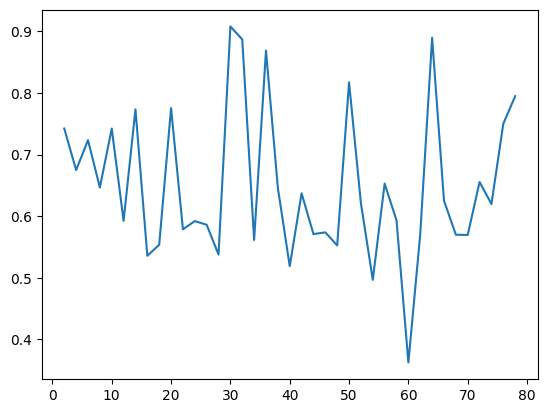

In [8]:
plt.plot(range(2, 80, 2), accuracies)